# Step 4 - Text classification with Transformer

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Job Type

In [ ]:
def str_to_num_lst(x):
    x = x.replace("'", "").replace("[", "").replace("]", "").split(", ")
    return list(map(int, x))

In [ ]:
# Download and prepare dataset
train_df = pd.read_csv("/content/gdrive/MyDrive/practice_nlp_2022/data/tmp_type_train.csv")
train_df['job_description'] = train_df['job_description'].apply(lambda x: str_to_num_lst(x))
X_train = train_df["job_description"]
Y_train = train_df["y"]
y_train = np.asarray(Y_train).astype("float32")

test_df = pd.read_csv("/content/gdrive/MyDrive/practice_nlp_2022/data/tmp_type_test.csv")
test_df['job_description'] = test_df['job_description'].apply(lambda x: str_to_num_lst(x))
X_test = test_df["job_description"]
Y_test = test_df["y"]
y_test = np.asarray(Y_test).astype("float32")

In [ ]:
max_seq_len = 80

x_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen = max_seq_len)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen = max_seq_len)

##### Implement a Transformer block as a layer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Implement embedding layer
# Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Create classifier model using transformer layer

In [ ]:
# Transformer layer outputs one vector for each time step of our input sequence. 
# Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
max_features = 20000 

embed_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_seq_len,))
embedding_layer = TokenAndPositionEmbedding(max_seq_len, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model_type = keras.Model(inputs=inputs, outputs=outputs)
model_type.compile(
    optimizer = "adam", 
    loss = "sparse_categorical_crossentropy", 
    metrics = ["accuracy"]
)

##### Train and Evaluate

In [ ]:
history = model_type.fit(
    x_train, 
    y_train, 
    batch_size = 128, 
    epochs = 5, 
    validation_data = (x_test, y_test),
    callbacks = my_callbacks
)

Epoch 1/5
111/111 [==============================] - 9s 39ms/step - loss: 0.4710 - accuracy: 0.8847 - val_loss: 0.2331 - val_accuracy: 0.9258
Epoch 2/5
111/111 [==============================] - 3s 31ms/step - loss: 0.1669 - accuracy: 0.9536 - val_loss: 0.1182 - val_accuracy: 0.9640
Epoch 3/5
111/111 [==============================] - 4s 33ms/step - loss: 0.0914 - accuracy: 0.9742 - val_loss: 0.0790 - val_accuracy: 0.9734
Epoch 4/5
111/111 [==============================] - 3s 31ms/step - loss: 0.0638 - accuracy: 0.9803 - val_loss: 0.0714 - val_accuracy: 0.9822
Epoch 5/5
111/111 [==============================] - 2s 22ms/step - loss: 0.0501 - accuracy: 0.9841 - val_loss: 0.0675 - val_accuracy: 0.9816


In [ ]:
def loss_plot(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

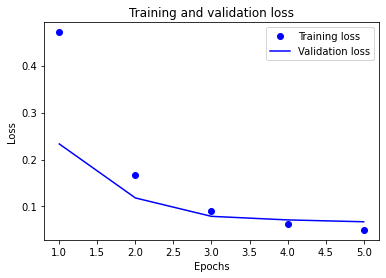

In [ ]:
loss_plot(history)

In [ ]:
score = model_type.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.06750018149614334
Test accuracy: 0.981596827507019


### Job Category

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/practice_nlp_2022/data/tmp_category_train.csv")
train_df['job_description'] = train_df['job_description'].apply(lambda x: str_to_num_lst(x))
X_train = train_df["job_description"]
Y_train = train_df["y"]
y_train = np.asarray(Y_train).astype("float32")

test_df = pd.read_csv("/content/gdrive/MyDrive/practice_nlp_2022/data/tmp_category_test.csv")
test_df['job_description'] = test_df['job_description'].apply(lambda x: str_to_num_lst(x))
X_test = test_df["job_description"]
Y_test = test_df["y"]
y_test = np.asarray(Y_test).astype("float32")

In [ ]:
max_seq_len = 80

x_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen = max_seq_len)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen = max_seq_len)

In [ ]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
max_features = 20000

embed_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_seq_len,))
embedding_layer = TokenAndPositionEmbedding(max_seq_len, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(11, activation="softmax")(x)

model_category = keras.Model(inputs=inputs, outputs=outputs)
model_category.compile(
    optimizer = "adam", 
    loss = "sparse_categorical_crossentropy", 
    metrics = ["accuracy"]
)

In [ ]:
history = model_category.fit(
    x_train, 
    y_train, 
    batch_size = 128, 
    epochs = 7, 
    validation_data = (x_test, y_test),
    callbacks = my_callbacks
)

Epoch 1/7
111/111 [==============================] - 6s 26ms/step - loss: 1.7949 - accuracy: 0.3682 - val_loss: 1.4068 - val_accuracy: 0.4672
Epoch 2/7
111/111 [==============================] - 2s 22ms/step - loss: 1.3232 - accuracy: 0.5023 - val_loss: 1.2330 - val_accuracy: 0.5173
Epoch 3/7
111/111 [==============================] - 2s 22ms/step - loss: 1.1447 - accuracy: 0.5527 - val_loss: 1.1147 - val_accuracy: 0.5481
Epoch 4/7
111/111 [==============================] - 2s 22ms/step - loss: 1.0560 - accuracy: 0.5890 - val_loss: 1.0947 - val_accuracy: 0.5566
Epoch 5/7
111/111 [==============================] - 2s 22ms/step - loss: 1.0012 - accuracy: 0.6030 - val_loss: 1.0462 - val_accuracy: 0.5620
Epoch 6/7
111/111 [==============================] - 2s 22ms/step - loss: 0.9493 - accuracy: 0.6164 - val_loss: 1.0620 - val_accuracy: 0.5535
Epoch 7/7
111/111 [==============================] - 2s 22ms/step - loss: 0.9207 - accuracy: 0.6256 - val_loss: 1.0311 - val_accuracy: 0.5614


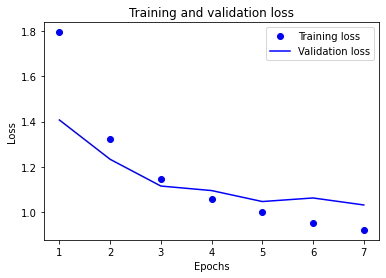

In [ ]:
loss_plot(history)

In [ ]:
score = model_category.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 1.0310890674591064
Test accuracy: 0.561438262462616
